In [1]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import scipy
import torch
import torch.nn as nn

from random import shuffle
from scipy.stats import gamma, beta, nbinom, poisson
from scipy.special import gammaln, betaln
from torch.autograd import Variable
from utils import *

%matplotlib inline

mpl.rcParams['axes.titlesize'] = 20
mpl.rcParams['axes.labelsize'] = 15
mpl.rcParams['ytick.labelsize'] = 12
mpl.rcParams['xtick.labelsize'] = 12
mpl.rcParams['legend.fontsize'] = 12
mpl.rcParams['figure.figsize'] = (15, 5)

## Compare two Poisson models with different priors

In [2]:
sample_size = 1  # size of toy data
n_samples = 20000

# generate data 
true_lam = 0.5
X_o = np.random.poisson(lam=true_lam, size=sample_size)
X_var = Variable(torch.Tensor(X_o.astype(float)))

# set prior parameters 
shapes = [0.5, 7.5]
scales = [1.0, 1.0]

# create priors 
prior0 = gamma(a=shapes[0], scale=scales[0])
prior1 = gamma(a=shapes[1], scale=scales[1])

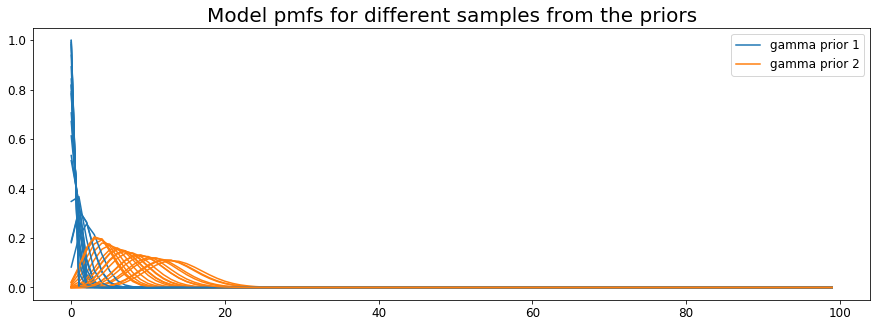

In [3]:
k = np.arange(100)

for i in range(20): 
    plt.plot(k, poisson.pmf(k, prior0.rvs()), 'C0')
    plt.plot(k, poisson.pmf(k, prior1.rvs()), 'C1')
    
plt.title('Model pmfs for different samples from the priors')
plt.legend(['gamma prior 1', 'gamma prior 2']);

## Define functions for generating data from the two different models

In [4]:
def generate_dataset(n_samples, sample_size): 
    
    X = []
    thetas = []
    m = []

    # for every sample we want a triplet (m_i, theta, sx)
    for i in range(n_samples): 
        
        # sample model index 
        m_i = np.round(np.random.rand()).astype(int)
    
        # generate data from model 
        # m_i in {0, 1} just sets the index in the array of prior hyperparams
        theta, x = generate_poisson(sample_size, prior1 if m_i else prior0)
        sx = calculate_stats(x)
    
        X.append(sx)
        thetas.append([theta])
        m.append([int(m_i)])
    
    return m, np.array(thetas), np.array(X)

## Define networks for fitting the posterior over model parameters 

In [5]:
class MDN_phi(nn.Module):
    def __init__(self, ndim_input=1, ndim_output=1, n_hidden=5, n_components=1):
        super(MDN_phi, self).__init__()
        self.fc_in = nn.Linear(1, n_hidden)
        self.tanh = nn.Tanh()
        self.scale_out = torch.nn.Sequential(
              nn.Linear(n_hidden, n_components),
              nn.Softplus())
        self.shape_out = torch.nn.Sequential(
              nn.Linear(n_hidden, n_components),
              nn.Softplus())

    def forward(self, x):
        out = self.fc_in(x)
        act = self.tanh(out)
        out_shape = self.scale_out(act)
        out_scale = self.shape_out(act)
        return (out_shape, out_scale)
    
def gamma_mdn_loss(out_shape, out_scale, y):
    result = gamma_pdf(y, out_shape, out_scale, log=True)
    result = torch.mean(result)  # mean over batch
    return -result

def train(X, Y, model, optim, lossfun, n_epochs=500, n_minibatch=50):
    dataset_train = [(x, y) for x, y in zip(X, Y)]

    for epoch in range(n_epochs): 
        bgen = batch_generator(dataset_train, n_minibatch)

        for j, (x_batch, y_batch) in enumerate(bgen):
            x_var = Variable(torch.Tensor(x_batch))
            y_var = Variable(torch.Tensor(y_batch))
                                                            
            (out_shape, out_scale) = model(x_var)
            loss = lossfun(out_shape, out_scale, y_var)
            
            optim.zero_grad()
            loss.backward()
            optim.step()

        if (epoch + 1) % 50 == 0:
            print("[epoch %04d] loss: %.4f" % (epoch + 1, loss.data[0]))
    
    return model, optim

## Generate a large data set of triplets (m, theta, sx)

Then separate it into sets for model 1 and model 2 and train the phi networks separately. 

In [6]:
# generate data 
m, theta, X= generate_dataset(n_samples, sample_size)
X, norm = normalize(X)

In [7]:
# separate it 
mask = np.array(m).squeeze()
theta1, X1, = theta[mask==0], X[mask==0, :]
theta2, X2, = theta[mask==1], X[mask==1, :]

## Train the phi networks for estimating the posteriors over $\mu$

In [8]:
# now train the networks for the two models 
n_epochs = 500
n_minibatch = 100
model1 = MDN_phi()
optim1 = torch.optim.Adam(model1.parameters(), lr=0.01)
model1, optim1 = train(X1, theta1, model1, optim1, lossfun=gamma_mdn_loss, n_epochs=n_epochs, n_minibatch=100)

[epoch 0050] loss: -0.3001
[epoch 0100] loss: 0.0338
[epoch 0150] loss: -0.2113
[epoch 0200] loss: -0.0757
[epoch 0250] loss: -0.3034
[epoch 0300] loss: -0.1660
[epoch 0350] loss: -0.4688
[epoch 0400] loss: -0.1390
[epoch 0450] loss: -0.3095
[epoch 0500] loss: -0.2015


In [9]:
model2 = MDN_phi()
optim2 = torch.optim.Adam(model2.parameters(), lr=0.01)
model2, optim2 = train(X2, theta2, model=model2, optim=optim2, lossfun=gamma_mdn_loss, n_epochs=n_epochs, n_minibatch=100)

[epoch 0050] loss: 2.0101
[epoch 0100] loss: 1.9912
[epoch 0150] loss: 2.1230
[epoch 0200] loss: 2.0071
[epoch 0250] loss: 1.8913
[epoch 0300] loss: 2.2001
[epoch 0350] loss: 1.8472
[epoch 0400] loss: 1.9208
[epoch 0450] loss: 2.0106
[epoch 0500] loss: 2.0502


In [10]:
thetas = np.linspace(0, 10, 1000)
post1 = get_posterior(model1, X_o, thetas, norm)
post2 = get_posterior(model2, X_o, thetas, norm)

In [11]:
prior1 = gamma.pdf(x=thetas, a=shapes[0], scale=scales[0])
prior2 = gamma.pdf(x=thetas, a=shapes[1], scale=scales[1])

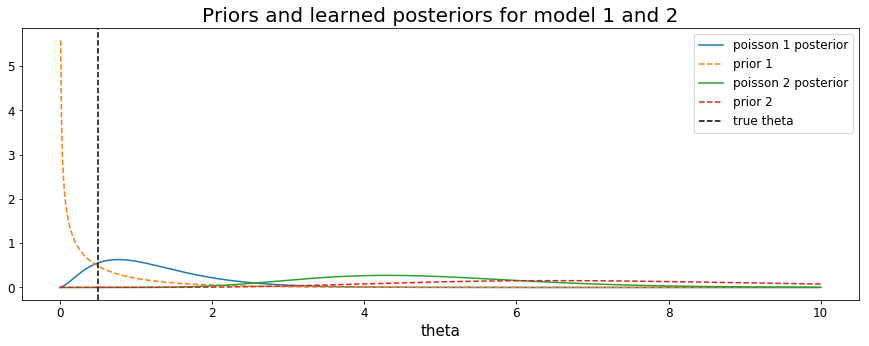

In [12]:
plt.plot(thetas, post1.squeeze(), label='poisson 1 posterior')
plt.plot(thetas, prior1, '--', label='prior 1')

plt.plot(thetas, post2.squeeze(), label='poisson 2 posterior')
plt.plot(thetas, prior2, '--', label='prior 2')

plt.axvline(x=true_lam, label='true theta', linestyle='--', color='k')
plt.xlabel('theta')
plt.title('Priors and learned posteriors for model 1 and 2')
plt.legend();

## Now train the model posterior

In [13]:
class MDN_psi(nn.Module):
    
    def __init__(self, ndim_input=1, ndim_output=2, n_hidden=5, n_components=1):
        super(MDN_psi, self).__init__()
        self.fc_in = nn.Linear(ndim_input, n_hidden)
        self.tanh = nn.Tanh()
        self.m_out = nn.Linear(n_hidden, ndim_output)

    def forward(self, x):
        out = self.fc_in(x)
        act = self.tanh(out)
        out_m = self.m_out(act)
        return out_m

def train_psi(X, Y, model, optim, lossfun, n_epochs=500, n_minibatch=50):
    dataset_train = [(x, y) for x, y in zip(X, Y)]
    
    losses = []

    for epoch in range(n_epochs): 
        bgen = batch_generator(dataset_train, n_minibatch)

        for j, (x_batch, y_batch) in enumerate(bgen):
            x_var = Variable(torch.Tensor(x_batch))            
            y_var = Variable(torch.LongTensor(y_batch)).view(n_minibatch)
            
            (out_act) = model(x_var)
            loss = lossfun(out_act, y_var)
            
            optim.zero_grad()
            loss.backward()
            optim.step()
            
            losses.append(loss.data[0])

        if (epoch + 1) % 100 == 0:
            print("[epoch %04d] loss: %.4f" % (epoch + 1, loss.data[0]))
    
    return model, optim, losses

In [14]:
model = MDN_psi(n_hidden=10)
optim = torch.optim.Adam(model.parameters(), lr=0.001)
lossfun = nn.CrossEntropyLoss()

model_psi, optim_psi, losses = train_psi(X, m, model, optim, lossfun, n_epochs=200, n_minibatch=100)

[epoch 0100] loss: 0.1690
[epoch 0200] loss: 0.1165


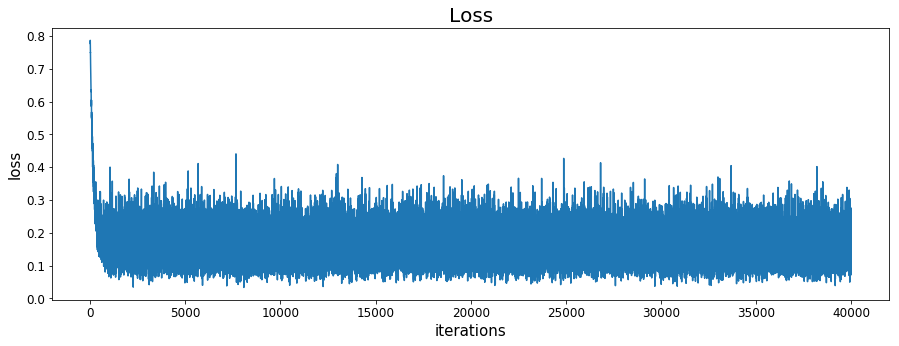

In [15]:
plt.figure(figsize=(15, 5))
plt.plot(losses)
plt.xlabel('iterations')
plt.ylabel('loss')
plt.title('Loss');

## Draw many samples and compare predicted to analytical Bayes Factor

In [16]:
bf_true = []
bf_predicted = []
bf_stats = []
model_indices = []
mi_pred = []

# gather summary stats
stats = []

Ntest = 50
for i in range(Ntest): 
    
    # sample model index 
    m_i = np.round(np.random.rand()).astype(int)
    
    # draw samples from the model given by the model index 
    if m_i == 0: 
        samples = np.random.poisson(0.5, sample_size)
    elif m_i == 1: 
        samples = np.random.poisson(6.0, sample_size)
    
    # apply model for prediction
    stats_o = np.array(calculate_stats(samples)).reshape(1, 1)
    stats_o, norm = normalize(stats_o, norm)
    
    stats.append(stats_o)
    
    X_var = Variable(torch.Tensor(stats_o))
    (out_act) = model(X_var)
    
    # in this vector, index 0 is Poi, index 1 is NB
    posterior_probs = nn.Softmax()(out_act).data.numpy()[0]
    # predict the model with the larger posterior 
    mi_pred.append(np.argmax(posterior_probs))
    
    # because we use a uniform prior the posterior ratio corresponds to the likelihood (evidence) ratio
    e0 = poisson_evidence(samples, shapes[0], scales[0], sample_size, log=True)
    e1 = poisson_evidence(samples, shapes[1], scales[1], sample_size, log=True)
    
    e0s = poisson_sum_evidence(samples, shapes[0], scales[0])
    e1s = poisson_sum_evidence(samples, shapes[1], scales[1])

    # calculate bf
    log_bftrue = e0 - e1
    log_bfstats = e0s - e1s
    log_bfpred = np.log(posterior_probs[0]) - np.log(posterior_probs[1])
    
    # append to lists
    bf_predicted.append(log_bfpred)
    bf_true.append(log_bftrue)
    bf_stats.append(log_bfstats)
    model_indices.append(m_i)
    
mi_true = np.array(model_indices)
mi_pred = np.array(mi_pred)
# we predict m0 if logbf > 0 
mi_ana = (np.array(bf_true) < 0.)
mi_pred = (np.array(bf_predicted) < 0.)
stats = np.array(stats).squeeze()

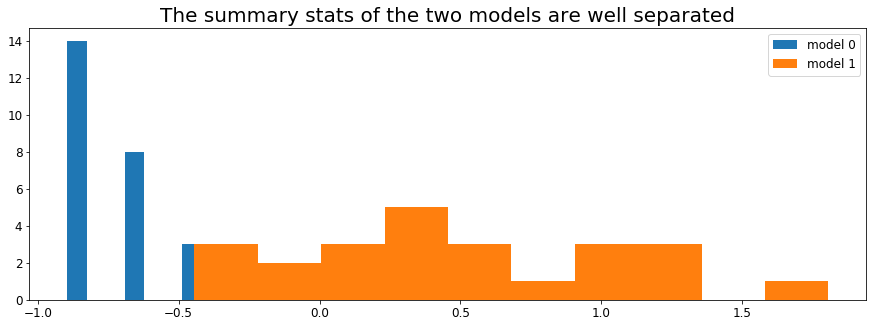

In [17]:
plt.title('The summary stats of the two models are well separated')
plt.hist(stats[mi_true==0], label='model 0')
plt.hist(stats[mi_true==1], label='model 1')
plt.legend(); 

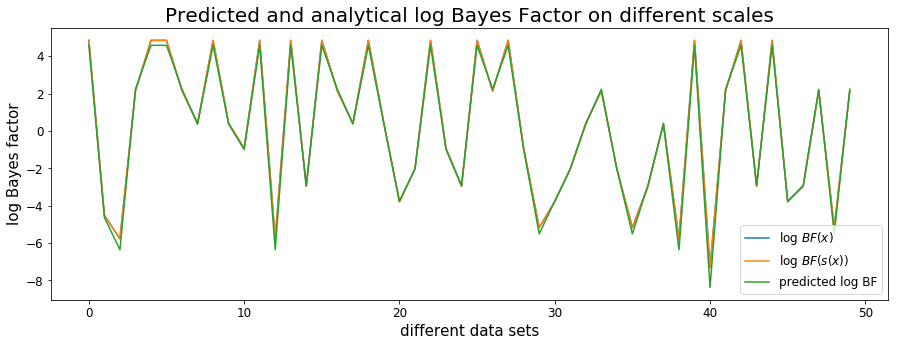

In [18]:
plt.plot(bf_true, label=r'log $BF(x)$')
plt.plot(bf_stats, label=r'log $BF(s(x))$')

plt.plot(bf_predicted, label='predicted log BF')
plt.ylabel('log Bayes factor')
plt.xlabel('different data sets')
plt.legend(loc=4)
plt.title('Predicted and analytical log Bayes Factor on different scales');

In [19]:
np.corrcoef(bf_true, bf_predicted)

array([[ 1.        ,  0.99828894],
       [ 0.99828894,  1.        ]])

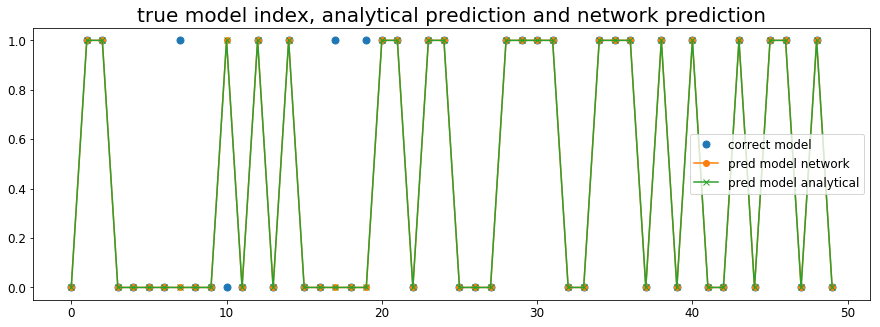

In [20]:
plt.figure(figsize=(15, 5))
plt.plot(mi_true, 'o', label='correct model', alpha=1., markersize=7, lw=3)
plt.plot(mi_pred, 'o-', label='pred model network')
plt.plot(mi_ana, 'x-', label='pred model analytical', alpha=1.)
plt.legend()
plt.title('true model index, analytical prediction and network prediction');